In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn import ensemble
from sklearn.model_selection import cross_val_score
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

# Note the warning about dtypes.

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [ ]:
#from sklearn import ensemble
#from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)

#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [4]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [4]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [5]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [7]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,11.99,332.10,31000.0,28.69,0.0,...,0,0,0,0,0,1,0,0,0,0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,11.99,797.03,79000.0,3.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,15.99,316.07,35000.0,30.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,19.99,317.86,64400.0,27.19,1.0,...,0,0,1,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [11]:
#from sklearn import ensemble
#from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.98176205, 0.98116837, 0.98211826, 0.98195203, 0.98074092,
       0.98002802, 0.96492436, 0.98095419, 0.98109668, 0.98095419])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [29]:
import seaborn as sns

# Import stat packages
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.stats import ttest_ind
from scipy.stats import zscore
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm

#from sklearn.preprocessing import Imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### Data Exploration

In [12]:
y2015.loan_status.value_counts()

Current               287414
Fully Paid             87989
Charged Off            29178
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

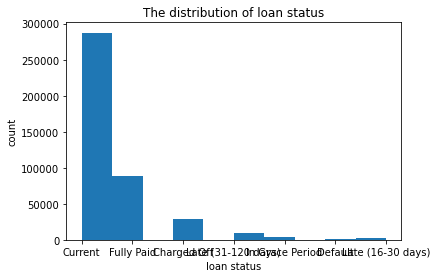

In [13]:
plt.hist(y2015.loan_status)
plt.title("The distribution of loan status")
plt.xlabel("loan status")
plt.ylabel("count")
plt.show()

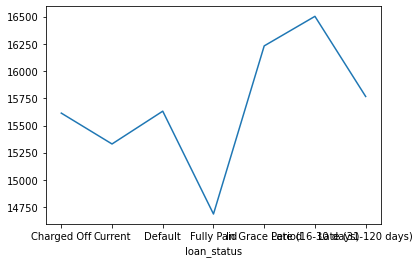

In [295]:
# It appears loan status has something to do with how much is on the loan
y2015.groupby('loan_status')['loan_amnt'].mean().plot()

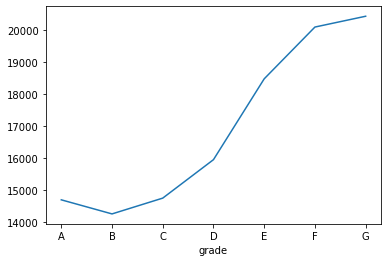

In [301]:
# there seems to be a relationship between grade and loan amount.
y2015.groupby('grade')['loan_amnt'].mean().plot()

In [57]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [40]:
y2015.shape

(421095, 103)

In [359]:
# make new df to preserve the previous version
y2015_2 = y2015.copy()

In [335]:
# Count how many nulls there are per column
total_nulls = y2015_2.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = y2015_2.isna().sum()* 100 / len(y2015_2)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
dti_joint                         420586
annual_inc_joint                  420584
verification_status_joint         420584
il_util                           402478
mths_since_rcnt_il                400285
open_acc_6m                       399723
inq_last_12m                      399723
total_cu_tl                       399723
inq_fi                            399723
all_util                          399723
max_bal_bc                        399723
open_rv_24m                       399723
open_rv_12m                       399723
total_bal_il                      399723
open_il_24m                       399723
open_il_12m                       399723
open_il_6m                        399723
mths_since_last_record            346680
mths_since_recent_bc_dlq          312495
mths_since_last_major_derog       298366
mths_since_recent_revol_delinq    269358
mths_since_last_delinq            203962
next_pymnt_d                      117167
mths_since_recent_inq             

The goal is to decrease the unnecessary variables. In this case, lets start with the columns that lack the majority data.

In [336]:
drop_list = y2015_2.loc[:, y2015_2.isna().sum()* 100 / len(y2015_2) > 30].columns
drop_list

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq'],
      dtype='object')

In [477]:
y2015_3 = y2015_2.drop(drop_list, axis = 1).copy()

In [441]:
# Count how many nulls there are per column
total_nulls = y2015_3.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = y2015_3.isna().sum()* 100 / len(y2015_3)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
next_pymnt_d                  117167
mths_since_recent_inq          44599
emp_length                     23817
num_tl_120dpd_2m               19230
mo_sin_old_il_acct             12254
percent_bc_gt_75                4239
bc_util                         4227
bc_open_to_buy                  3963
mths_since_recent_bc            3798
last_pymnt_d                     294
title                            132
last_credit_pull_d                 8
num_rev_accts                      1
grade                              0
funded_amnt                        0
loan_amnt                          0
total_acc                          0
initial_list_status                0
out_prncp                          0
out_prncp_inv                      0
total_pymnt_inv                    0
total_pymnt                        0
pub_rec                            0
total_rec_prncp                    0
total_rec_int                      0
total_rec_late_fee                 0
member_id      

Not done yet. There are still variables with nulls but we should handle these a bit more carefully.

In [442]:
y2015_3.describe(include = 'all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,4.210950e+05,4.210950e+05,421095.000000,421095.000000,421095.000000,421095,421095.000000,421095.000000,421095,397278,421095,4.210950e+05,421095,421095,421095,421095,421095,420963,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,4.210950e+05,421095.000000,421095,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,420801,421095.000000,303928,421087,421095.000000,421095.0,421095,421095.000000,421095.000000,4.210950e+05,4.210950e+05,421095.00000,421095.000000,417132.000000,416868.000000,421095.000000,421095.000000,408841.000000,421095.000000,421095.000000,421095.000000,421095.000000,417297.000000,376496.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,421094.000000,421095.000000,421095.000000,401865.000000,421095.000000,421095.000000,421095.000000,421095.000000,416856.000000,421095.000000,421095.000000,4.210950e+05,4.210950e+05,421095.000000,4.210950e+05
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7,11,4,NaN,3,12,7,1,14,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,4,26,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,C,10+ years,MORTGAGE,NaN,Source Verified,Oct-2015,Current,n,debt_consolidation,Debt consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan-2017,NaN,Feb-2017,Jan-2017,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,283173,NaN,NaN,120567,141521,207683,NaN,179565,48631,287414,421095,250020,249926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261646,NaN,262670,354426,NaN,NaN,420584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.393097e+07,5.759576e+07,15240.285862,15240.285862,15234.156412,NaN,12.600388,441.860087,NaN,NaN,NaN,7.696561e+04,NaN,NaN,NaN,NaN,NaN,NaN,19.195989,0.347397,0.572690,11.948643,0.233776,1.768548e+04,25.493468,NaN,7221.518316,7218.407431,9272.455831,9268.964681,7098.480969,2119.537282,0.548363,53.889215,9.443726,NaN,2641.275728,NaN,NaN,0.020240,1.0,NaN,0.006087,257.478241,1.400755e+05,3.365771e+04,4.66500,13104.784721,9636.063992,62.228136,0.010420,13.765184,127.567419,186.586697,13.451247,8.013204,1.685261,24.856534,6.751163,0.527054,3.740966,5.860832,4.799879,8.137138,8.649001,8.431786,14.883601,5.809238,11.894537,0.000761,0.004042,0.094318,2.170947,93.924313,47.527110,0.133188,0.064556,1.734070e+05,5.222199e+04,21958

In [478]:
y2015_3.nunique().sort_values()

policy_code                        1
pymnt_plan                         1
application_type                   2
term                               2
initial_list_status                2
verification_status                3
next_pymnt_d                       4
home_ownership                     4
num_tl_120dpd_2m                   5
num_tl_30dpd                       5
grade                              7
inq_last_6mths                     7
loan_status                        7
acc_now_delinq                     8
collections_12_mths_ex_med        10
chargeoff_within_12_mths          10
emp_length                        11
pub_rec_bankruptcies              11
issue_d                           12
purpose                           14
tax_liens                         25
num_tl_90g_dpd_24m                25
last_pymnt_d                      25
last_credit_pull_d                26
mths_since_recent_inq             26
delinq_2yrs                       26
title                             27
p

2 variables (policy_code and pymnt_plan) only have 1 non-unique value in the entire df. There's no value gained from those columns, so let's boot them out. 

In [483]:
# drop pymnt_plan and policy code... they only have 1 value for the entire df
y2015_3 = y2015_3.drop(['pymnt_plan'], axis = 1)

In [484]:
y2015_3 = y2015_3.drop(['policy_code'], axis = 1)

In [445]:
y2015_3.dtypes

id                            float64
member_id                     float64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
purpose                        object
title                          object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
total_acc                     float64
initial_list_status            object
out_prncp                     float64
out_prncp_in

In [485]:
y2015_3.shape

(421095, 79)

In [486]:
y2015_3.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,10+ years,MORTGAGE,48000.0,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,33.18,0.0,0.0,11.0,2.0,19108.0,19.0,w,13668.88,13668.88,4519.68,4519.68,2331.12,2188.56,0.0,0.0,0.0,Jan-2017,379.39,Jan-2017,Jan-2017,0.0,INDIVIDUAL,0.0,0.0,31329.0,284700.0,6.0,2848.0,263953.0,17.6,0.0,0.0,131.0,294.0,11.0,6.0,2.0,11.0,11.0,2.0,6.0,9.0,6.0,8.0,6.0,9.0,11.0,9.0,11.0,0.0,0.0,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,8 years,MORTGAGE,60000.0,Not Verified,Dec-2015,Current,credit_card,Credit card refinancing,22.44,0.0,0.0,7.0,0.0,7722.0,9.0,w,6635.69,6635.69,3572.97,3572.97,2964.31,608.66,0.0,0.0,0.0,Jan-2017,298.58,Jan-2017,Jan-2017,0.0,INDIVIDUAL,0.0,0.0,55387.0,13000.0,2.0,7912.0,4778.0,61.8,0.0,0.0,234.0,91.0,9.0,9.0,0.0,11.0,9.0,0.0,3.0,3.0,3.0,3.0,5.0,4.0,4.0,3.0,7.0,0.0,0.0,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,10+ years,MORTGAGE,109000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,26.02,0.0,1.0,9.0,0.0,20862.0,19.0,w,0.00,0.00,26224.23,26224.23,25000.00,1224.23,0.0,0.0,0.0,Sep-2016,20807.39,NaN,Jan-2017,0.0,INDIVIDUAL,0.0,0.0,305781.0,38400.0,2.0,33976.0,17538.0,54.3,0.0,0.0,142.0,168.0,13.0,13.0,3.0,13.0,0.0,0.0,3.0,3.0,5.0,6.0,7.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,10+ years,MORTGAGE,92000.0,Not Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,21.60,0.0,0.0,16.0,0.0,51507.0,24.0,w,19263.77,19263.77,10271.36,10271.36,8736.23,1535.13,0.0,0.0,0.0,Jan-2017,858.05,Jan-2017,Jan-2017,0.0,INDIVIDUAL,0.0,0.0,221110.0,79900.0,1.0,13819.0,16623.0,59.9,0.0,0.0,82.0,379.0,19.0,19.0,2.0,19.0,NaN,0.0,7.0,9.0,9.0,11.0,4.0,13.0,18.0,9.0,16.0,0.0,0.0,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,8 years,RENT,55000.0,Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,25.49,0.0,4.0,18.0,1.0,9568.0,19.0,w,0.00,0.00,9190.49,9190.49,8650.00,540.49,0.0,0.0,0.0,May-2016,8251.42,NaN,Jun-2016,0.0,INDIVIDUAL,0.0,0.0,18926.0,20750.0,17.0,1051.0,1375.0,45.0,0.0,0.0,129.0,95.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,17.0,2.0,2.0,2.0,17.0,17.0,13.0,18.0,NaN,0.0,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


Notice that a few columns, like emp_length, have special characters and/or a mix of words and numeric values in each cell. We can clean these up by splitting the strings and returning only the numeric data.

In [487]:
y2015_3.emp_length.value_counts()

10+ years    141521
2 years       37497
< 1 year      34340
3 years       33430
1 year        27473
5 years       24930
4 years       24506
8 years       21560
7 years       18414
6 years       16838
9 years       16769
Name: emp_length, dtype: int64

In [488]:
# split strings and return only numeric data
y2015_3['emp_length'] = y2015_3['emp_length'].str.split(n=1).str[0]

# special case... "<" is in reference to <1 years. There is already a 1 year value, so we will make this a 0.5 value for
# distinction.
y2015_3.loc[(y2015_3.emp_length == '<'), 'emp_length'] = 0.5
y2015_3.loc[(y2015_3.emp_length == '10+'), 'emp_length'] = 10
y2015_3['term'] = y2015_3['term'].str.split(n=1).str[0]

#y2015_3['issue_yr'] = y2015_3['issue_d'].str.split('-').str[1]
#y2015_3['issue_month'] = y2015_3['issue_d'].str.split('-').str[0]
#y2015_3['last_pymnt_month'] = y2015_3['last_pymnt_d'].str.split('-').str[0]
#y2015_3['last_pymnt_yr'] = y2015_3['last_pymnt_d'].str.split('-').str[1]
#y2015_3['next_pymnt_yr'] = y2015_3['next_pymnt_d'].str.split('-').str[1]
#y2015_3['next_pymnt_month'] = y2015_3['next_pymnt_d'].str.split('-').str[0]
#y2015_3['last_credit_pull_yr'] = y2015_3['last_credit_pull_d'].str.split('-').str[1]
#y2015_3['last_credit_pull_month'] = y2015_3['last_credit_pull_d'].str.split('-').str[0]

In [449]:
y2015_3.sample(30)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
378592,40503368.0,43368225.0,15000.0,15000.0,15000.0,36,6.99,463.09,A,5,MORTGAGE,90000.0,Source Verified,Feb-2015,Current,credit_card,Credit card refinancing,17.19,3.0,0.0,12.0,0.0,5436.0,25.0,f,6208.53,6208.53,10208.080000,10208.08,8791.47,1416.61,0.0,0.00,0.0000,Dec-2016,463.09,Feb-2017,Jan-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,230798.0,7500.0,2.0,20982.0,994.0,68.9,0.0,0.0,163.0,136.0,12.0,12.0,1.0,12.0,24.0,0.0,2.0,4.0,4.0,10.0,6.0,7.0,18.0,4.0,12.0,0.0,0.0,0.0,1.0,88.0,50.0,0.0,0.0,283812.0,31390.0,3200.0,68183.0
398041,39659353.0,42483067.0,4000.0,4000.0,4000.0,36,10.49,130.00,B,4,OWN,52000.0,Not Verified,Jan-2015,Current,debt_consolidation,Debt consolidation,27.42,1.0,1.0,6.0,0.0,6187.0,26.0,f,1475.12,1475.12,3114.170000,3114.17,2524.88,589.29,0.0,0.00,0.0000,Jan-2017,130.00,Feb-2017,Jan-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,12927.0,17895.0,4.0,2155.0,140.0,80.0,0.0,0.0,128.0,287.0,10.0,8.0,3.0,10.0,4.0,3.0,1.0,4.0,1.0,6.0,5.0,4.0,18.0,4.0,6.0,0.0,0.0,0.0,2.0,69.2,100.0,0.0,0.0,27770.0,12927.0,700.0,9875.0
55971,65424486.0,70011278.0,1000.0,1000.0,1000.0,36,13.67,34.02,C,2,RENT,54000.0,Source Verified,Nov-2015,Fully Paid,debt_consolidation,Debt consolidation,10.67,3.0,0.0,12.0,0.0,1500.0,18.0,w,0.00,0.00,1036.960000,1036.96,1000.00,36.96,0.0,0.00,0.0000,Apr-2016,226.64,NaN,Dec-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,18097.0,8500.0,3.0,1508.0,901.0,81.2,0.0,0.0,19.0,207.0,16.0,16.0,0.0,16.0,3.0,0.0,2.0,2.0,3.0,3.0,1.0,11.0,17.0,3.0,12.0,0.0,0.0,0.0,0.0,87.5,33.3,0.0,0.0,27402.0,18097.0,2200.0,18902.0
304736,46814543.0,49962349.0,24000.0,24000.0,24000.0,36,5.93,729.37,A,10,MORTGAGE,85000.0,Verified,Apr-2015,Current,credit_card,Credit card refinancing,5.92,0.0,0.0,2.0,0.0,20617.0,8.0,w,11193.77,11193.77,14579.490000,14579.49,12806.23,1773.26,0.0,0.00,0.0000,Dec-2016,729.37,Jan-2017,Jan-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,135722.0,25000.0,0.0,67861.0,4383.0,82.5,0.0,0.0,134.0,345.0,124.0,58.0,3.0,345.0,NaN,0.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,154126.0,20617.0,25000.0,0.0
230501,54533632.0,58114352.0,35000.0,35000.0,35000.0,60,13.33,802.29,C,4,RENT,101000.0,Verified,Jul-2015,Current,debt_consolidation,Debt consolidation,39.52,0.0,0.0,8.0,0.0,31432.0,15.0,w,26810.84,26810.84,14581.470000,14581.47,8189.16,6392.31,0.0,0.00,0.0000,Jan-2017,802.29,Feb-2017,Jan-2017,0.0,1.0,INDIVIDUAL,0.0,0.0,81542.0,40200.0,2.0,10193.0,8118.0,76.7,0.0,0.0,26.0,220.0,19.0,19.0,0.0,19.0,14.0,0.0,3.0,4.0,4.0,10.0,2.0,5.0,12.0,4.0,8.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,120695.0,81542.0,34800.0,60000.0
58972,65423218.0,70009964.0,24000.0,24000.0,23750.0,36,8.18,754.07,B,9,RENT,112000.0,Source Verified,Nov-2015,Current,credit_card,Credit card refinancing,10.80,0.0,0.0,7.0,0.0,19794.0,13.0,f,15356.96,15197.00,10546.070000,10436.22,8643.04,1903.03,0.0,0.00,0.0000,Jan-2017,754.07,Feb-2017,Jan-2017,0.0,1.0,INDIVIDUAL,0.

In [489]:
y2015_3.dtypes

id                            float64
member_id                     float64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
purpose                        object
title                          object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
total_acc                     float64
initial_list_status            object
out_prncp                     float64
out_prncp_in

Pulling out some columns of the df might give us some clues as to why certain nulls exist. Example, next_pymnt_d is null because the loan_status is "Fully Paid". Therefore, the null is not a true error. We can still learn from this data by exchanging NaN with NONE. That way, get_dummies will be able to use this information down the line.

In [490]:
y2015_3[['last_pymnt_d','next_pymnt_d', 'loan_amnt', 'term', 'loan_status', 'mths_since_recent_inq', 'last_credit_pull_d', 'emp_length']].sample(30)

,last_pymnt_d,next_pymnt_d,loan_amnt,term,loan_status,mths_since_recent_inq,last_credit_pull_d,emp_length
81368,Jan-2017,Jan-2017,6000.0,36,Late (31-120 days),0.0,Jan-2017,8
281611,Jan-2017,Feb-2017,5000.0,36,Current,10.0,Jan-2017,10
52372,Jan-2017,Feb-2017,14400.0,36,Current,2.0,Jan-2017,1
317417,Jun-2016,NaN,19000.0,36,Fully Paid,NaN,Jul-2016,10
5894,Jul-2016,NaN,3000.0,36,Fully Paid,0.0,Jan-2017,NaN
1288,Jan-2017,Feb-2017,8000.0,36,Current,5.0,Jan-2017,2
242943,Jan-2017,Feb-2017,35000.0,60,Current,2.0,Jan-2017,3
314121,Jan-2017,Jan-2017,12000.0,60,Current,1.0,Jan-2017,10
82883,Jan-2017,Feb-2017,28000.0,36,Current,5.0,Jan-2017,1
399725,Jun-2015,NaN,32000.0,60,Charged Off,7.0,Jan-2017,4


In [491]:
# fill next_pymnt_d NaN's with "NONE" 
# They are paid off
y2015_3['next_pymnt_d'] = y2015_3['next_pymnt_d'].fillna("NONE")

# filling with 0s 
y2015_3['mths_since_recent_inq'] = y2015_3['mths_since_recent_inq'].fillna(0)

In [492]:
y2015_3.loan_status.value_counts()

Current               287414
Fully Paid             87989
Charged Off            29178
Late (31-120 days)      9510
In Grace Period         4320
Late (16-30 days)       1888
Default                  796
Name: loan_status, dtype: int64

There are a couple of columns that categorical but also ranked...one of them happen to be our target, loan_status.
Assigning numeric values in the place of strings might help when we are reviewing correlation coeficients and any potential calculations.

In [493]:
# categorical data to numeric data
grade_dict = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7}
loan_status_dict = {'Default' : 1, 'Late (31-120 days)' : 2, 'Late (16-30 days)' : 3, 'In Grace Period' : 4, 'Charged Off' : 5, 'Current' : 6, 'Fully Paid' : 7}

In [494]:
y2015_3['grade'] = y2015_3['grade'].map(grade_dict)
y2015_3['loan_status_ranked'] = y2015_3['loan_status'].map(loan_status_dict)

We've fixed nulls and formatting in a few columns and now we need to change them from floats to numeric.

In [496]:
y2015_3.grade = y2015_3.grade.astype('float64')
y2015_3['term'] = (y2015_3['term'] == '36').astype('int64')
y2015_3.emp_length = y2015_3.emp_length.astype('float64')

We've removed a lot of nulls by dropping columns and filling in with meaningful values. Let's drop the remaining rows with nulls and see how this model holds up.

In [497]:
y2015_4 = y2015_3.dropna().copy()

In [498]:
y2015_4.shape

(365036, 80)

In [499]:
# Count how many nulls there are per column
total_nulls = y2015_4.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = y2015_4.isna().sum()* 100 / len(y2015_4)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
loan_status_ranked            0
total_il_high_credit_limit    0
pub_rec                       0
revol_bal                     0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collection_recovery_fee       0
last_pymnt_d                  0
last_pymnt_amnt               0
next_pymnt_d                  0
last_credit_pull_d            0
open_acc                      0
inq_last_6mths                0
delinq_2yrs                   0
grade                         0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
emp_length       

In [500]:
y2015_4.dtypes

id                            float64
member_id                     float64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                            int64
int_rate                      float64
installment                   float64
grade                         float64
emp_length                    float64
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
purpose                        object
title                          object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
total_acc                     float64
initial_list_status            object
out_prncp                     float64
out_prncp_in

Now that we've removed all the nulls, we can move forward on to feature selection.

In [501]:
num_cols = y2015_4.select_dtypes(exclude = object).columns
word_cols = y2015_4.select_dtypes(include = object).columns

In [502]:
num_cols

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_r

In [503]:
word_cols

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')

In [504]:
# Comparing correlation strength with "loan_status_ranked", sorted on correlation value.

num_corr = abs(y2015_4[y2015_4.columns[2:]].corr()['loan_status_ranked'][:]).sort_values()
print(num_corr)

delinq_amnt                   0.000163
tot_coll_amt                  0.000492
num_tl_30dpd                  0.000863
chargeoff_within_12_mths      0.000885
pub_rec_bankruptcies          0.001011
num_tl_120dpd_2m              0.001095
num_bc_sats                   0.001744
acc_now_delinq                0.001800
revol_bal                     0.005834
num_accts_ever_120_pd         0.006448
total_bal_ex_mort             0.006860
num_il_tl                     0.007213
pub_rec                       0.008359
total_il_high_credit_limit    0.008762
num_tl_90g_dpd_24m            0.009459
tax_liens                     0.009507
mo_sin_old_il_acct            0.010590
mths_since_recent_inq         0.011041
collections_12_mths_ex_med    0.011937
num_op_rev_tl                 0.012536
mths_since_recent_bc          0.013003
mo_sin_rcnt_rev_tl_op         0.013906
mo_sin_rcnt_tl                0.015141
emp_length                    0.015403
open_acc                      0.017818
num_sats                 

In [505]:
lower_corr_df = pd.DataFrame(num_corr)
lower_corr_df.columns = ['CorrelationLoanStatus']

# make drop list from columns with correlation coef less than 0.1.
to_drop = lower_corr_df[lower_corr_df['CorrelationLoanStatus'] < 0.1].index

# Drop features 
y2015_5 = y2015_4.drop(to_drop, axis=1)

In [506]:
num_cols_2 = y2015_5.select_dtypes(exclude = object).columns

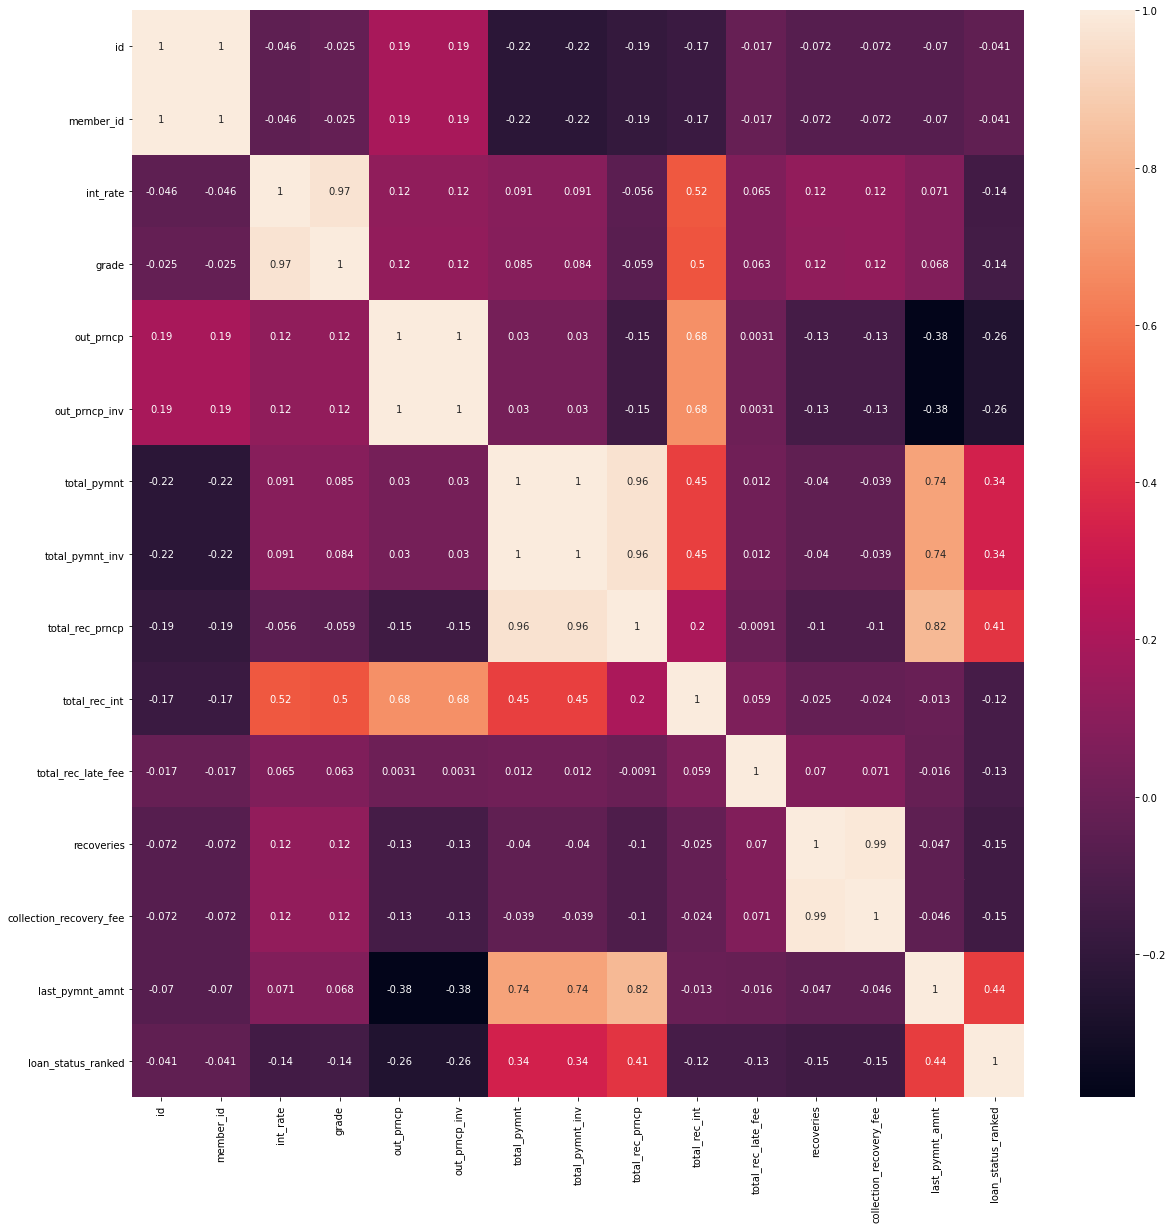

In [507]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(y2015_4[num_cols_2].corr(),annot=True)

We dropped many columns with poor correlation coef with the target but now we need to address multicolinear relationships to avoid over fitting.

In [508]:
# Create correlation matrix
corr_matrix = y2015_5[num_cols_2].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
y2015_5.drop(to_drop, axis=1, inplace=True)

In [509]:
y2015_5.sample(10)

,id,int_rate,home_ownership,verification_status,issue_d,loan_status,purpose,title,initial_list_status,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,application_type,loan_status_ranked
184891,55942235.0,5.32,MORTGAGE,Not Verified,Aug-2015,Current,credit_card,Credit card refinancing,w,15838.66,14842.55,1756.21,0.0,0.0,Jan-2017,871.08,Feb-2017,Jan-2017,INDIVIDUAL,6
98556,62559567.0,9.99,MORTGAGE,Verified,Oct-2015,Fully Paid,debt_consolidation,Debt consolidation,w,0.00,8729.60,729.60,0.0,0.0,Nov-2016,5886.06,NONE,Nov-2016,INDIVIDUAL,7
72600,63970312.0,5.32,MORTGAGE,Not Verified,Nov-2015,Current,debt_consolidation,Debt consolidation,w,4409.30,2949.27,358.57,0.0,0.0,Jan-2017,210.81,Feb-2017,Jan-2017,INDIVIDUAL,6
165600,58533223.0,19.99,RENT,Verified,Aug-2015,Late (31-120 days),debt_consolidation,Debt consolidation,f,8954.38,3935.70,2300.08,15.0,0.0,Nov-2016,560.24,Feb-2017,Jan-2017,INDIVIDUAL,2
179251,57156744.0,15.61,RENT,Verified,Aug-2015,Current,medical,Medical expenses,w,7022.96,7112.05,2135.01,0.0,0.0,Jan-2017,419.58,Feb-2017,Jan-2017,INDIVIDUAL,6
144220,60246092.0,12.29,OWN,Source Verified,Sep-2015,Late (31-120 days),credit_card,Credit card refinancing,f,6888.82,4383.19,1147.01,0.0,0.0,Oct-2016,337.70,Feb-2017,Jan-2017,INDIVIDUAL,2
56561,65571378.0,16.55,MORTGAGE,Verified,Nov-2015,Fully Paid,moving,Moving and relocation,f,0.00,5111.99,111.99,0.0,0.0,Jan-2016,5121.18,NONE,Nov-2016,INDIVIDUAL,7
118774,61490204.0,19.19,RENT,Source Verified,Oct-2015,Current,debt_consolidation,Debt consolidation,w,21608.20,10129.98,5738.18,0.0,0.0,Jan-2017,677.18,Feb-2017,Jan-2017,INDIVIDUAL,6
96504,62724733.0,9.99,MORTGAGE,Source Verified,Oct-2015,Charged Off,credit_card,Credit card refinancing,w,0.00,3379.26,802.15,0.0,0.0,May-2016,483.94,NONE,Dec-2016,INDIVIDUAL,5
76453,63947678.0,12.59,MORTGAGE,Verified,Nov-2015,Current,credit_card,Credit card refinancing,w,9825.11,7023.95,1849.06,0.0,0.0,Jan-2017,502.46,Feb-2017,Jan-2017,INDIVIDUAL,6


### Categorical Variable Selection

In [511]:
# new numeric column list
drop_num_list = [col_name for col_name in y2015_5.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "loan_status_ranked"]]

In [539]:
# new dummies df
df_dummies = y2015_5.copy()

# drop columns from drop_num_list
df_dummies = df_dummies.drop(drop_num_list, axis = 1)
df_dummies = df_dummies.drop('loan_status', axis = 1)

In [544]:
num_cols_3 = y2015_5.select_dtypes(exclude = object).columns.copy()
word_cols_2 = df_dummies.select_dtypes(include = object).columns.copy()

In [545]:
# running get dummies

# elected NOT to remove the first column because not every feature can be taken into account by deduction, especially where 
# multiple conditions are present. Also, not every dummy variable exists throughout the whole data set... 

df_dummies= pd.get_dummies(data = df_dummies, columns = word_cols_2)

In [546]:
df_dummies.head()

,id,loan_status_ranked,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Apr-2015,issue_d_Aug-2015,issue_d_Dec-2015,issue_d_Feb-2015,issue_d_Jan-2015,issue_d_Jul-2015,issue_d_Jun-2015,issue_d_Mar-2015,issue_d_May-2015,issue_d_Nov-2015,issue_d_Oct-2015,issue_d_Sep-2015,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,title_Business,title_Car financing,title_Credit Card/Auto Repair,title_Credit card refinancing,title_Debt consolidation,title_DebtC,title_Green loan,title_Home buying,title_Home improvement,title_Learning and training,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_New Baby and New House (CC Consolidate),title_Other,title_Pay off Lowes Card,title_Paying off higher interest cards & auto,title_SAVE,title_Simple Loan Until Contract Is Completed,title_Student Loan,title_Trying to come back to reality!,title_Vacation,title_considerate,title_new day,title_new kitchen for momma!,title_odymeds,initial_list_status_f,initial_list_status_w,last_pymnt_d_Apr-2015,last_pymnt_d_Apr-2016,last_pymnt_d_Aug-2015,last_pymnt_d_Aug-2016,last_pymnt_d_Dec-2015,last_pymnt_d_Dec-2016,last_pymnt_d_Feb-2015,last_pymnt_d_Feb-2016,last_pymnt_d_Jan-2015,last_pymnt_d_Jan-2016,last_pymnt_d_Jan-2017,last_pymnt_d_Jul-2015,last_pymnt_d_Jul-2016,last_pymnt_d_Jun-2015,last_pymnt_d_Jun-2016,last_pymnt_d_Mar-2015,last_pymnt_d_Mar-2016,last_pymnt_d_May-2015,last_pymnt_d_May-2016,last_pymnt_d_Nov-2015,last_pymnt_d_Nov-2016,last_pymnt_d_Oct-2015,last_pymnt_d_Oct-2016,last_pymnt_d_Sep-2015,last_pymnt_d_Sep-2016,next_pymnt_d_Feb-2017,next_pymnt_d_Jan-2017,next_pymnt_d_Jul-2016,next_pymnt_d_Mar-2017,next_pymnt_d_NONE,last_credit_pull_d_Apr-2015,last_credit_pull_d_Apr-2016,last_credit_pull_d_Aug-2015,last_credit_pull_d_Aug-2016,last_credit_pull_d_Dec-2014,last_credit_pull_d_Dec-2015,last_credit_pull_d_Dec-2016,last_credit_pull_d_Feb-2015,last_credit_pull_d_Feb-2016,last_credit_pull_d_Jan-2015,last_credit_pull_d_Jan-2016,last_credit_pull_d_Jan-2017,last_credit_pull_d_Jul-2015,last_credit_pull_d_Jul-2016,last_credit_pull_d_Jun-2015,last_credit_pull_d_Jun-2016,last_credit_pull_d_Mar-2015,last_credit_pull_d_Mar-2016,last_credit_pull_d_May-2015,last_credit_pull_d_May-2016,last_credit_pull_d_Nov-2015,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT
0,68009401.0,6,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,68354783.0,6,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,68466916.0,7,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,68466961.0,6,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,68506798.0,6,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [547]:
correlation_cat = abs(df_dummies[df_dummies.columns[1:]].corr()["loan_status_ranked"][:]).sort_values()
print(correlation_cat)

title_Pay off Lowes Card                         0.000024
title_DebtC                                      0.000024
title_Simple Loan Until Contract Is Completed    0.000024
title_Paying off higher interest cards & auto    0.000024
title_New Baby and New House (CC Consolidate)    0.000024
title_considerate                                0.000024
title_new day                                    0.000024
next_pymnt_d_Jul-2016                            0.000024
title_Student Loan                               0.000024
title_SAVE                                       0.000024
title_odymeds                                    0.000024
home_ownership_ANY                               0.000034
purpose_medical                                  0.000144
title_Green loan                                 0.000203
purpose_renewable_energy                         0.000204
title_Medical expenses                           0.000212
title_Home buying                                0.000495
purpose_house 

In [548]:
lower_cat_corr_df_2 = pd.DataFrame(correlation_cat)
lower_cat_corr_df_2.columns = ['CorrelationLoanStatus']

In [549]:
to_drop_cat = lower_cat_corr_df_2[lower_cat_corr_df_2['CorrelationLoanStatus'] < 0.1].index
# Drop features 
df_dummies_2 = df_dummies.drop(to_drop_cat, axis=1)

In [550]:
df_dummies_2.head()

,id,loan_status_ranked,last_pymnt_d_Sep-2016,next_pymnt_d_Feb-2017,next_pymnt_d_NONE,last_credit_pull_d_Aug-2016,last_credit_pull_d_Dec-2016,last_credit_pull_d_Jan-2017,last_credit_pull_d_Jul-2016
0,68009401.0,6,0,0,0,0,0,1,0
1,68354783.0,6,0,0,0,0,0,1,0
2,68466916.0,7,1,0,1,0,0,1,0
3,68466961.0,6,0,0,0,0,0,1,0
5,68506798.0,6,0,0,0,0,0,1,0


In [551]:
# drop categorical variables from original data frame "y2015_5"
y2015_6 = y2015_5.select_dtypes(exclude=['object'])

In [552]:
# merging dfs on id and target
merged_df_hp = pd.merge(y2015_6, df_dummies_2, on= ['id','loan_status_ranked'])

In [553]:
merged_df_hp.head()

,id,int_rate,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,loan_status_ranked,last_pymnt_d_Sep-2016,next_pymnt_d_Feb-2017,next_pymnt_d_NONE,last_credit_pull_d_Aug-2016,last_credit_pull_d_Dec-2016,last_credit_pull_d_Jan-2017,last_credit_pull_d_Jul-2016
0,68009401.0,14.85,13668.88,4519.68,2188.56,0.0,0.0,379.39,6,0,0,0,0,0,1,0
1,68354783.0,7.49,6635.69,3572.97,608.66,0.0,0.0,298.58,6,0,0,0,0,0,1,0
2,68466916.0,7.49,0.00,26224.23,1224.23,0.0,0.0,20807.39,7,1,0,1,0,0,1,0
3,68466961.0,6.49,19263.77,10271.36,1535.13,0.0,0.0,858.05,6,0,0,0,0,0,1,0
4,68506798.0,8.49,19143.69,5634.12,1777.81,0.0,0.0,471.77,6,0,0,0,0,0,1,0


In [554]:
merged_df_hp.shape

(365036, 16)

# PCA

In [555]:
# model feature list
feature_list = [col_name for col_name in merged_df_hp.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "loan_status_ranked"]]

In [556]:
x = merged_df_hp[feature_list].values
y = merged_df_hp['loan_status_ranked']
x = StandardScaler().fit_transform(x)

In [567]:
hp_pca = PCA(n_components=6)

principalComponents = hp_pca.fit_transform(x)

principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6'])

Text(0, 0.5, 'Cumulative explained variance')

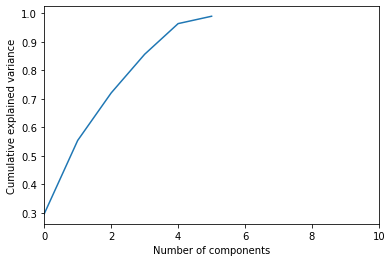

In [568]:
plt.plot(np.cumsum(hp_pca.explained_variance_ratio_))
plt.xlim(0,10,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [575]:
#principalDataframe = pd.concat([principalDataframe, merged_df_hp], axis=1)
hp_pca_df = pd.concat([principalDataframe, merged_df_hp], axis=1)

In [576]:
hp_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,id,int_rate,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,loan_status_ranked,last_pymnt_d_Sep-2016,next_pymnt_d_Feb-2017,next_pymnt_d_NONE,last_credit_pull_d_Aug-2016,last_credit_pull_d_Dec-2016,last_credit_pull_d_Jan-2017,last_credit_pull_d_Jul-2016
0,0.190434,-1.095157,-0.037087,-0.172587,-0.337207,-0.590855,68009401.0,14.85,13668.88,4519.68,2188.56,0.0,0.0,379.39,6,0,0,0,0,0,1,0
1,-1.521636,-0.410381,-0.478901,0.224695,0.412015,-0.138348,68354783.0,7.49,6635.69,3572.97,608.66,0.0,0.0,298.58,6,0,0,0,0,0,1,0
2,0.429361,4.033373,-0.753048,0.371201,0.915603,-0.415732,68466916.0,7.49,0.00,26224.23,1224.23,0.0,0.0,20807.39,7,1,0,1,0,0,1,0
3,-0.127587,-0.786602,-1.144615,0.462019,1.453566,-0.707197,68466961.0,6.49,19263.77,10271.36,1535.13,0.0,0.0,858.05,6,0,0,0,0,0,1,0
4,-0.169043,-1.215133,-0.864946,0.293644,0.954657,-0.889745,68506798.0,8.49,19143.69,5634.12,1777.81,0.0,0.0,471.77,6,0,0,0,0,0,1,0


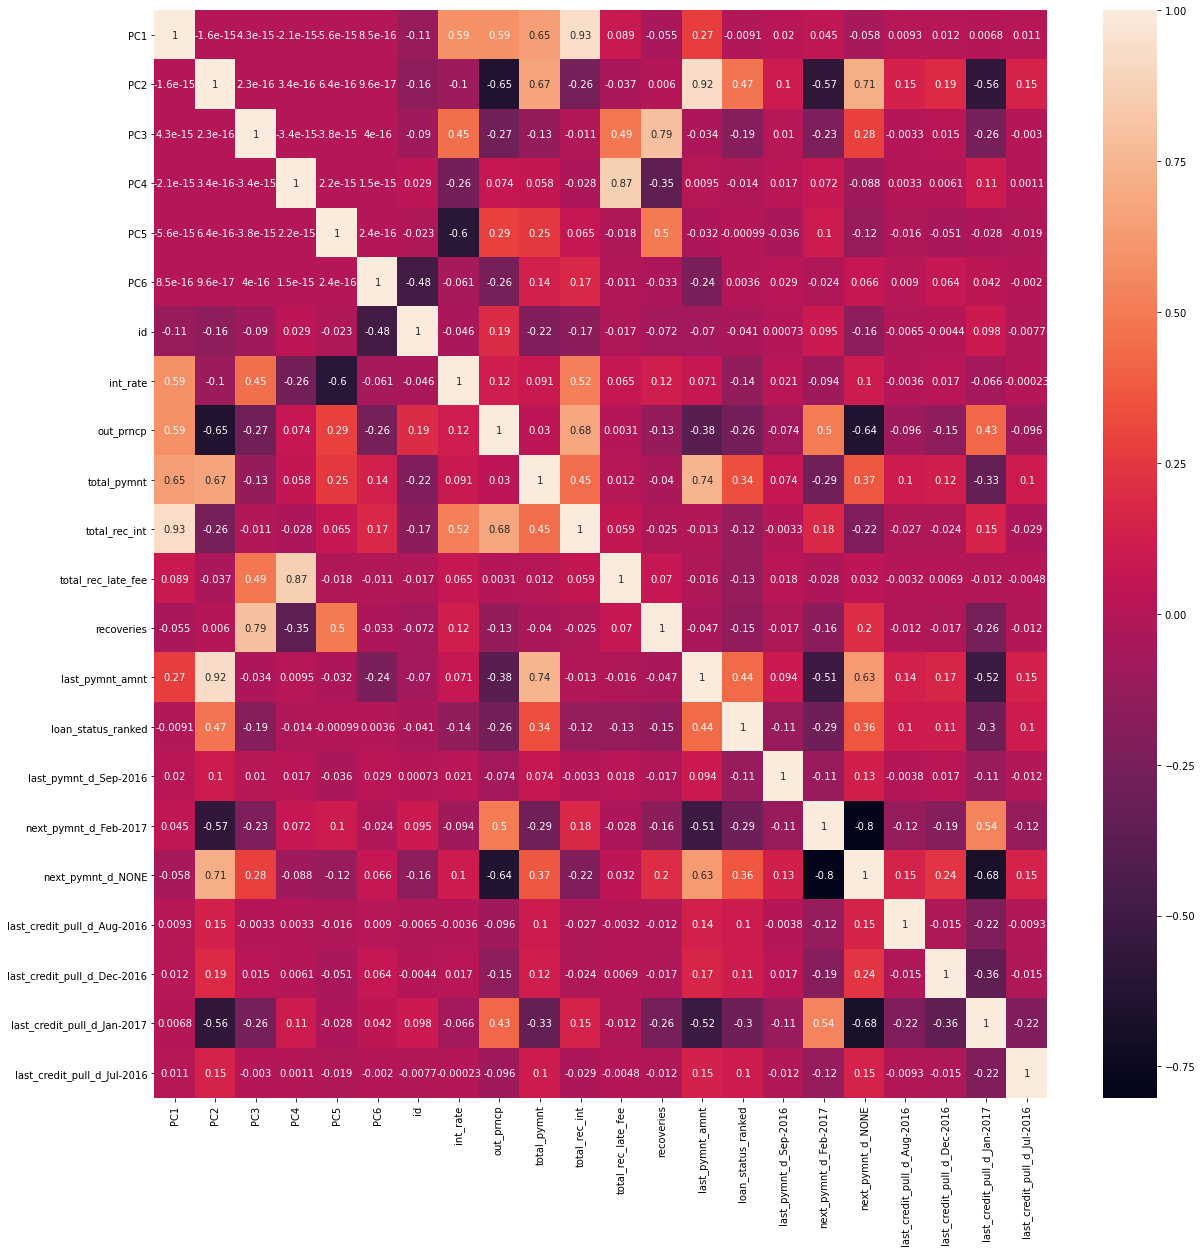

In [561]:
# See the correlation heatmap of the features
plt.figure(figsize=(20,20))
sns.heatmap(hp_pca_df.corr(),annot=True)

In [562]:
correlation_cat = abs(hp_pca_df[hp_pca_df.columns[0:]].corr()['loan_status_ranked'][:]).sort_values()
print(correlation_cat)

PC5                            0.000995
PC6                            0.003557
PC1                            0.009127
PC4                            0.013633
id                             0.040813
last_credit_pull_d_Aug-2016    0.104147
last_credit_pull_d_Jul-2016    0.104376
last_credit_pull_d_Dec-2016    0.108700
last_pymnt_d_Sep-2016          0.113378
total_rec_int                  0.124651
total_rec_late_fee             0.125881
int_rate                       0.139818
recoveries                     0.146571
PC3                            0.194891
out_prncp                      0.261482
next_pymnt_d_Feb-2017          0.288492
last_credit_pull_d_Jan-2017    0.301081
total_pymnt                    0.336803
next_pymnt_d_NONE              0.360641
last_pymnt_amnt                0.442879
PC2                            0.473888
loan_status_ranked             1.000000
Name: loan_status_ranked, dtype: float64


In [577]:
lower_corr_df = pd.DataFrame(correlation_cat)

lower_corr_df.columns = ['correlation_cat']
lower_corr_df = lower_corr_df.drop(['id','loan_status_ranked'])

In [578]:
to_drop_corr = lower_corr_df[lower_corr_df['correlation_cat'] < 0.2].index
print(to_drop_corr)

Index(['PC5', 'PC6', 'PC1', 'PC4', 'last_credit_pull_d_Aug-2016',
       'last_credit_pull_d_Jul-2016', 'last_credit_pull_d_Dec-2016',
       'last_pymnt_d_Sep-2016', 'total_rec_int', 'total_rec_late_fee',
       'int_rate', 'recoveries', 'PC3'],
      dtype='object')


In [579]:
# Drop features 
hp_pca_df = hp_pca_df.drop(to_drop_corr, axis=1)

In [580]:
hp_pca_df.head()

,PC2,id,out_prncp,total_pymnt,last_pymnt_amnt,loan_status_ranked,next_pymnt_d_Feb-2017,next_pymnt_d_NONE,last_credit_pull_d_Jan-2017
0,-1.095157,68009401.0,13668.88,4519.68,379.39,6,0,0,1
1,-0.410381,68354783.0,6635.69,3572.97,298.58,6,0,0,1
2,4.033373,68466916.0,0.00,26224.23,20807.39,7,0,1,1
3,-0.786602,68466961.0,19263.77,10271.36,858.05,6,0,0,1
4,-1.215133,68506798.0,19143.69,5634.12,471.77,6,0,0,1


In [581]:
hp_pca_df = hp_pca_df.drop('PC2', axis = 1)

In [582]:
# model feature list
feature_list = [col_name for col_name in hp_pca_df.select_dtypes(['int64', 'float64']).columns.copy()
              if col_name not in ["id", "loan_status_ranked"]]

In [583]:
hp_pca_df.head()

,id,out_prncp,total_pymnt,last_pymnt_amnt,loan_status_ranked,next_pymnt_d_Feb-2017,next_pymnt_d_NONE,last_credit_pull_d_Jan-2017
0,68009401.0,13668.88,4519.68,379.39,6,0,0,1
1,68354783.0,6635.69,3572.97,298.58,6,0,0,1
2,68466916.0,0.00,26224.23,20807.39,7,0,1,1
3,68466961.0,19263.77,10271.36,858.05,6,0,0,1
4,68506798.0,19143.69,5634.12,471.77,6,0,0,1


## 3rd Random Forest

In [585]:
# how few features can we use and stay above 90%?

rfc = RandomForestClassifier()
X = hp_pca_df.drop(['id','loan_status_ranked'], 1)
Y = hp_pca_df['loan_status_ranked']
#X = pd.get_dummies(X)
#X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.81873219, 0.95342976, 0.94299255, 0.94715648, 0.93397984,
       0.93460991, 0.89830973, 0.94156645, 0.9412925 , 0.95359286])

Can this model work without using anything related to payment amount or outstanding principal? How do you know?

- The short answer is no.
- The majority of the variables left in the model consist of payment and principal values. In addition, we observed that the loan amount is decently correlated with the loan status in an earlier graph. In fact, loan amount is 0 when the status is paid off. 